# Crypto trading platform with OpenAI Gym
> Learn how to build a Bitcoin trading platform using real market data with the OpenAI Gym environment.

- toc: false
- badges: true
- comments: true
- author: dzlab
- categories: [tensorflow, reinforcement]

https://github.com/PacktPublishing/Tensorflow-2-Reinforcement-Learning-Cookbook/tree/master/Chapter07/tradegym

In this article we will build a cryptocurrency trading exchange with OpenAI Gym and using real-world data from the Gemini cryptocurrency exchange. This environment will enable us to develop and train RL agents capable of performing crypto trading. i.e. buy/sell or hold crypto tokens and get rewarded accordingly by either reporting a profit or a loss.

In [19]:
#collapse-hide
%%capture
%%bash

mkdir -p data

curl -o data/Gemini_BTCUSD_d.csv https://raw.githubusercontent.com/PacktPublishing/Tensorflow-2-Reinforcement-Learning-Cookbook/master/Chapter04/data/Gemini_BTCUSD_d.csv

curl -o data/Gemini_ETHUSD_d.csv https://raw.githubusercontent.com/PacktPublishing/Tensorflow-2-Reinforcement-Learning-Cookbook/master/Chapter04/data/Gemini_ETHUSD_d.csv


First, lets install the dependencies need to be able to run this notebook: OpenAI Gym, xvfb X window server, and [mplfinance](https://github.com/matplotlib/mplfinance) for finantial data visualization.

In [20]:
%%capture
%%bash

apt install xvfb
pip install gym

pip install mplfinance

Second, lets import the necessary Python modules that we will need in the following sections.

In [21]:
import os
import random
from typing import Dict
import gym
import numpy as np
import pandas as pd
from gym import spaces
import plotly.express as px

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
from matplotlib import style
from mplfinance.original_flavor import candlestick_ohlc
from IPython import display
from matplotlib import animation

In [23]:
%matplotlib inline

Next, we define a configuration dictionnary that we will use to set the crypto ticket to trade, the initial balance available to the agent, window size of the number of days in the past, etc.


In [24]:
env_config = {
    "exchange": "Gemini", # Cryptocurrency exchange (Gemini, coinbase, kraken, etc.)
    "ticker": "BTCUSD", # CryptoFiat
    "frequency": "daily", # trading frequency daily/hourly/minutes
    "opening_account_balance": 100000, # Starting balance in USD
    "observation_horizon_sequence_length": 30, # Window size in days
    "order_size": 1, # Number of coins to buy per buy/sell order
}

Next, we define a class to facilitate the access to the crypto price data. This will hide the implementation details about where the data comes from, e.g. from a public API. In our case, for simplicity, the price data is available offline from a local CSV file.

The class also uses the previous configuration dictionnary, and exposes some utility functions like getting the current price of a symbol.


In [25]:
class TradingData:
    def __init__(self, env_config: Dict = env_config):
        self.ticker = env_config.get("ticker", "BTCUSD")
        data_dir = "data"
        self.exchange = env_config["exchange"]
        freq = env_config["frequency"]
        if freq == "daily":
            self.freq_suffix = "d"
        elif freq == "hourly":
            self.freq_suffix = "1hr"
        elif freq == "minutes":
            self.freq_suffix = "1min"

        self.ticker_file_stream = os.path.join(f"{data_dir}",f"{'_'.join([self.exchange, self.ticker,self.freq_suffix])}.csv",)
        assert os.path.isfile(self.ticker_file_stream), f"Cryptocurrency data file stream not found at: data/{self.ticker_file_stream}.csv"
        
        self.ohlcv_df = pd.read_csv(self.ticker_file_stream, parse_dates=True, index_col="Date", skiprows=1).sort_values(by="Date")
        if "USD" in self.ticker:  
            self.ohlcv_df["Volume"] = self.ohlcv_df[
                "Volume " + self.ticker[:-3]  # e.g: "Volume BTC"
            ]
        self.horizon = env_config.get("observation_horizon_sequence_length")
        self.observation_features = ["Open","High","Low","Close","Volume BTC","Volume USD",]

    def get_current_price(self, current_step):
        # Stochastically determine the current price based on Market Open and Close prices
        current_date = self.ohlcv_df.index[current_step]
        open_price = self.ohlcv_df.loc[current_date, "Open"]
        close_price = self.ohlcv_df.loc[current_date,"Close"]
        return random.uniform(open_price, close_price,)

    def get_size(self):
        return len(self.ohlcv_df.loc[:, "Open"].values)

    def get_observation(self, current_step):
        # Get crypto price info data table from input (file/live) stream
        first_date = self.ohlcv_df.index[current_step]
        last_date = self.ohlcv_df.index[current_step + self.horizon]
        observation = (
            self.ohlcv_df.loc[
                first_date : last_date,
                self.observation_features,
            ]
            .to_numpy()
            .T
        )
        return observation


We can visualize the data loaded by the `TradingData` class by showing the changes in Open, High, Low, Close (OHLC) prices of Bitcoin in this dataset.

In [26]:
data = TradingData()

In [27]:
df = data.ohlcv_df.reset_index()
df = df[['Date', 'Open', 'High', 'Low', 'Close']] #'Symbol'
df = df.melt(id_vars='Date', value_vars=['Open', 'High', 'Low', 'Close'], var_name='BTC')

px.line(df, x='Date', y='value', color='BTC' )

Next, we build a utility class that will visualize the state of our Crypto Trading Exchange using two charts:
- A chart for visualizing the balance of the Agent over time, this is a simple line chart of the balance
- A candlesticks chart of Open, High, Low, Close (OHLC) prices of Bitcoin, this is built using [mplfinance](https://github.com/matplotlib/mplfinance) library

In [28]:
class TradeVisualizer:

    def __init__(self, data, title=None):
        self.data = data
        
        self.account_balances = np.zeros(len(self.data.ohlcv_df.index))

        fig = plt.figure("Crypto Trading Exchange", figsize=[18, 10])
        nrows, ncols = 6, 1
        gs = fig.add_gridspec(nrows, ncols)
        row, col = 0, 0
        rowspan, colspan = 2, 1

        self.account_balance_ax = fig.add_subplot(
            gs[row : row + rowspan, col : col + colspan]
        )
        row, col = 2, 0
        rowspan, colspan = 8, 1
        
        self.price_ax = plt.subplot2grid(
            (nrows, ncols),
            (row, col),
            rowspan=rowspan,
            colspan=colspan,
            sharex=self.account_balance_ax,
        )
        self.price_ax = fig.add_subplot(gs[row : row + rowspan, col : col + colspan])

        self.viz_not_initialized = True
        self.fig = fig

    def _render_account_balance(self, current_step, account_balance, horizon):
        self.account_balance_ax.clear()
        date_range = self.data.ohlcv_df.index[current_step : current_step + len(horizon)]

        self.account_balance_ax.plot_date(
            date_range,
            self.account_balances[horizon],
            "-",
            label="Account Balance ($)",
            lw=1.0,
        )

        self.account_balance_ax.legend()
        legend = self.account_balance_ax.legend(loc=2, ncol=2)
        legend.get_frame().set_alpha(0.4)

        last_date = self.data.ohlcv_df.index[current_step + len(horizon)].strftime("%Y-%m-%d")
        last_date = matplotlib.dates.datestr2num(last_date)
        last_account_balance = self.account_balances[current_step]

        self.account_balance_ax.annotate(
            "{0:.2f}".format(account_balance),
            (last_date, last_account_balance),
            xytext=(last_date, last_account_balance),
            bbox=dict(boxstyle="round", fc="w", ec="k", lw=1),
            color="black",
        )

        self.account_balance_ax.set_ylim(
            min(self.account_balances[np.nonzero(self.account_balances)]) / 1.25,
            max(self.account_balances) * 1.25,
        )

        plt.setp(self.account_balance_ax.get_xticklabels(), visible=False)


    def _render_ohlc(self, current_step, dates, horizon):
        self.price_ax.clear()

        candlesticks = zip(
            dates,
            self.data.ohlcv_df["Open"].values[horizon],
            self.data.ohlcv_df["Close"].values[horizon],
            self.data.ohlcv_df["High"].values[horizon],
            self.data.ohlcv_df["Low"].values[horizon],
        )

        candlestick_ohlc(
            self.price_ax,
            candlesticks,
            width=np.timedelta64(1, "D"),
            colorup="g",
            colordown="r",
        )
        self.price_ax.set_ylabel(f"{self.data.ticker} Price ($)")
        self.price_ax.tick_params(axis="y", pad=30)

        last_date = self.data.ohlcv_df.index[current_step].strftime("%Y-%m-%d")
        last_date = matplotlib.dates.datestr2num(last_date)
        last_close = self.data.ohlcv_df["Close"].values[current_step]
        last_high = self.data.ohlcv_df["High"].values[current_step]

        self.price_ax.annotate(
            "{0:.2f}".format(last_close),
            (last_date, last_close),
            xytext=(last_date, last_high),
            bbox=dict(boxstyle="round", fc="w", ec="k", lw=1),
            color="black",
        )

        plt.setp(self.price_ax.get_xticklabels(), visible=False)

    def _render_trades(self, trades, horizon):
        for trade in trades:
            if trade["step"] in horizon:
                date = self.data.ohlcv_df.index[trade["step"]].strftime("%Y-%m-%d")
                date = matplotlib.dates.datestr2num(date)
                high = self.data.ohlcv_df["High"].values[trade["step"]]
                low = self.data.ohlcv_df["Low"].values[trade["step"]]

                if trade["type"] == "buy":
                    high_low = low
                    color = "g"
                    arrow_style = "<|-"
                else:  # sell
                    high_low = high
                    color = "r"
                    arrow_style = "-|>"

                proceeds = "{0:.2f}".format(trade["proceeds"])

                self.price_ax.annotate(
                    f"{trade['type']} ${proceeds}".upper(),
                    (date, high_low),
                    xytext=(date, high_low),
                    color=color,
                    arrowprops=(
                        dict(
                            color=color,
                            arrowstyle=arrow_style,
                            connectionstyle="angle3",
                        )
                    ),
                )

    def render(self, current_step, account_balance, trades, window_size=100):
        self.account_balances[current_step] = account_balance

        window_start = max(current_step - window_size, 0)
        step_range = range(window_start, current_step + 1)

        dates = self.data.ohlcv_df.index[step_range]

        self._render_account_balance(current_step, account_balance, step_range)
        self._render_ohlc(current_step, dates, step_range)
        self._render_trades(trades, step_range)
        
        self.fig.canvas.draw()
        fig_data = np.frombuffer(self.fig.canvas.tostring_rgb(), dtype=np.uint8)
        fig_data = fig_data.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))
        return fig_data

    def close(self):
        plt.close()

Next, we define the `TradingService` class which provides a set of API for the agent to execute a trade (sell or buy) and update accordingly the balance.

- `reset()` method used to reset the agent state (e.g. reset the balance to it's initial value, clear the list of trades executed so far by the agent)
- `execute_trade()`: executes Buy/Sell trade and update the account balance once the trade order has been executed.


In [29]:
class TradingService:
    def __init__(self, env_config: Dict = env_config, data = None):
        self.opening_account_balance = env_config["opening_account_balance"]
        self.horizon = env_config.get("observation_horizon_sequence_length")
        self.order_size = env_config.get("order_size")
        self.data = data if data else TradingData()

    def reset(self):
        # Reset the state of the environment to an initial state
        self.cash_balance = self.opening_account_balance
        self.account_value = self.opening_account_balance
        self.num_coins_held = 0
        self.cost_basis = 0
        self.trades = []

    def execute_buy(self, current_price, current_step):
        # Simulate a BUY order and execute it at current_price
        allowable_coins = int(self.cash_balance / current_price)
        if allowable_coins < self.order_size:
            # Not enough cash to execute a buy order
            return
        num_coins_bought = self.order_size
        current_cost = self.cost_basis * self.num_coins_held
        additional_cost = num_coins_bought * current_price
        self.cash_balance -= additional_cost
        self.cost_basis = (current_cost + additional_cost) / (self.num_coins_held + num_coins_bought)
        self.num_coins_held += num_coins_bought
        self.trades.append({
            "type": "buy",
            "step": current_step,
            "shares": num_coins_bought,
            "proceeds": additional_cost,
            })

    def execute_sell(self, current_price, current_step):
        # Simulate a SELL order and execute it at current_price
        if self.num_coins_held < self.order_size:
            # Not enough coins to execute a sell order
            return
        num_coins_sold = self.order_size
        self.cash_balance += num_coins_sold * current_price
        self.num_coins_held -= num_coins_sold
        sale_proceeds = num_coins_sold * current_price
        self.trades.append({
            "type": "sell",
            "step": current_step,
            "shares": num_coins_sold,
            "proceeds": sale_proceeds,
            })

    def execute_trade_action(self, action, current_step):
        if action == 0:  # Hold position
            return

        order_type = "buy" if action == 1 else "sell"
        current_price = self.data.get_current_price(current_step)

        if order_type == "buy":
            self.execute_buy(current_price, current_step)
        elif order_type == "sell":
            self.execute_sell(current_price, current_step)

        if self.num_coins_held == 0:
            self.cost_basis = 0
        # Update account value
        self.account_value = self.cash_balance + self.num_coins_held * current_price

Finally, we define the tranding exchange environment class that takes the previous implemented utility classes for trading, data and visualiztion. It will subclass the `gym.Env` interface and implement the following main methods:

- `reset()` method executed at the start of every episode to reset the state of the environment and the agent.
- `step()` method executed at each step of an episode, it takes the action (e.g. hold, sell, buy) selected by the agent and execute it. After that, it calculates the reward (i.e. the profit or loss corresponding to the action execution).
- `render()` method uses the `TraidingVisualizer` class to render the current state of the environment and the agent current balance.
- `close()` method closes all visualizations.

In [30]:
class TradingEnv(gym.Env):
    def __init__(self, service = None, data = None, env_config: Dict = env_config):
        super().__init__()
        self.data = data if data else TradingData()
        self.service = service if service else TradingService()
        self.opening_account_balance = env_config["opening_account_balance"]
        self.horizon = env_config.get("observation_horizon_sequence_length")
        self.viewer = None
        self.action_space = spaces.Discrete(3)
        self.observation_features = ["Open","High","Low","Close","Volume BTC","Volume USD",]
        self.observation_space = spaces.Box(low=0,high=1,shape=(len(self.observation_features),self.horizon + 1),dtype=np.float,)
        self.viz = None

    def step(self, action):
        # Execute one step within the trading environment
        self.service.execute_trade_action(action, self.current_step)
        self.current_step += 1
        account_value = self.service.account_value
        reward = account_value - self.opening_account_balance
        done = account_value <= 0 or self.current_step >= self.data.get_size()
        obs = self.data.get_observation(self.current_step)
        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.current_step = 0
        self.service.reset()
        if self.viz is None:
            self.viz = TradeVisualizer(self.data, "TradingEnv")
        return self.data.get_observation(self.current_step)

    def render(self, mode="rgb_array"):
        # Render the environment
        img = self.viz.render(self.current_step,self.service.account_value,self.service.trades,window_size=self.horizon,)
        if mode == "rgb_array":
            return img
        elif mode == "human":
            if self.viewer is None:
                from gym.envs.classic_control import rendering
                self.viewer = rendering.SimpleImageViewer()
            self.viewer.imshow(img)

    def close(self):
        if self.viz is not None:
            self.viz.close()
            self.viz = None


Now, we are ready to test our trading environment. For simplicity, we will run one episode and use a basic agent that will randomly select an action to be executed from the possible ones (buy, sell, or hold). We will keep track of the rewards from each action so we can display them later.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



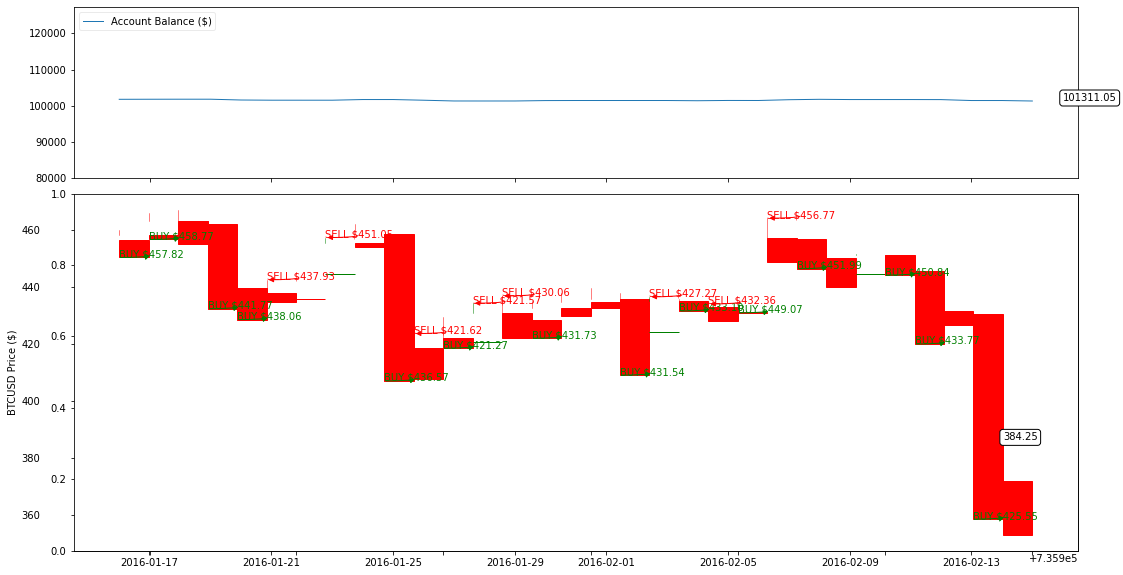

In [31]:
env = TradingEnv()
images, rewards = [], []
obs = env.reset()
for _ in range(100):
    action = env.action_space.sample()
    next_obs, reward, done, _ = env.step(action)
    images.append(env.render())
    rewards.append(reward)


After finishing the episode, we can display the evolution of the environment as well as the agent states as follows:

In [32]:
plt.rcParams['axes.grid'] = False

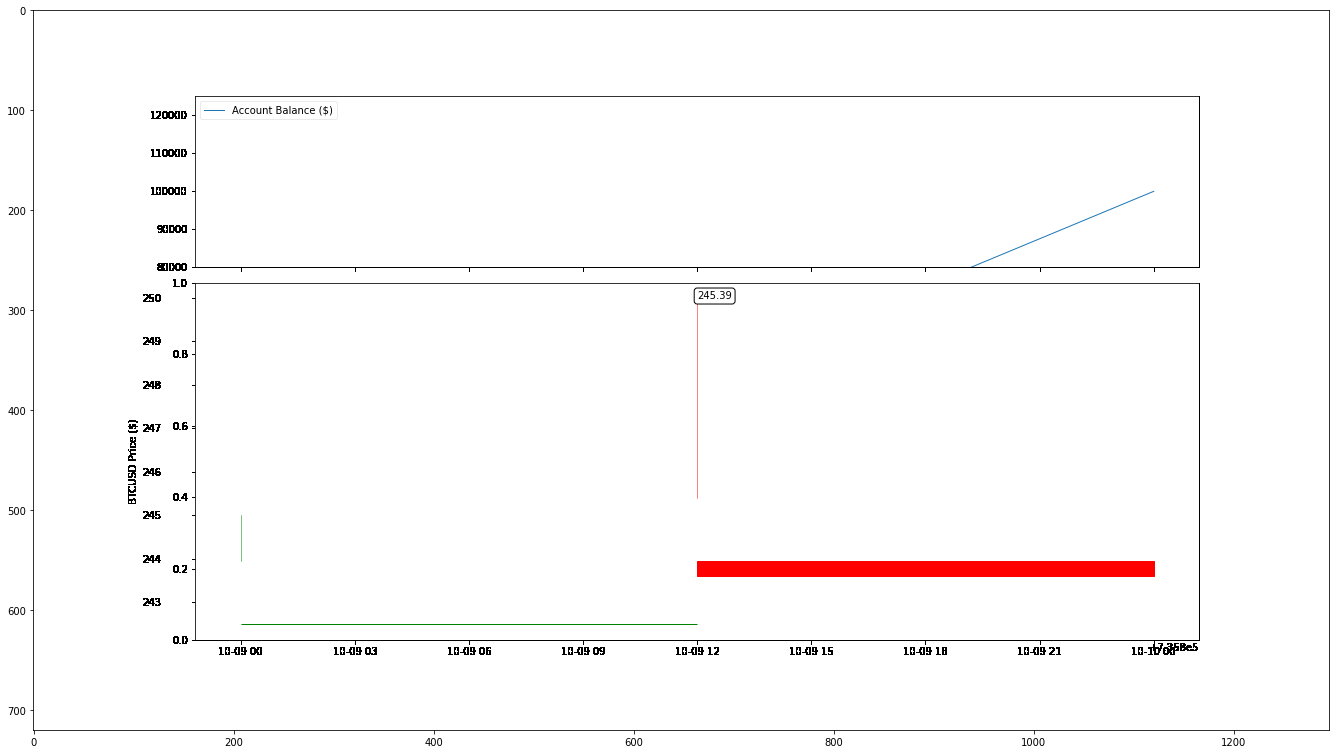

In [33]:
dpi = 72
interval = 50
fig = plt.figure(figsize=(images[0].shape[1]/dpi,images[0].shape[0]/dpi), dpi=dpi, frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

plt.axis=('off')
patch = ax.imshow(images[0])

animate = lambda i: patch.set_data(images[i])
ani = animation.FuncAnimation(fig, animate, frames=len(images),interval=interval)

The following video is the recoding of the states

In [34]:
display.display(display.HTML(ani.to_jshtml()))

We can display the rewards collected by the agent.

In [35]:
df = pd.DataFrame({"reward": rewards})
fig = px.line(df, y="reward", title='Rewards over time', labels=dict(index="Step", reward="Reward"))
fig.show()

Now we have an environment ready to use for testing different trading strategies, but this will be part of another article.

I hope you enjoyed this article, feel free to leave a comment or reach out on twitter [@bachiirc](https://twitter.com/bachiirc)